In [9]:
graph_req = ['aggregatedEndToEndLatencyAvg', 'aggregatedEndToEndLatency50pct', 'aggregatedEndToEndLatency75pct',
             'aggregatedEndToEndLatency95pct', 'aggregatedEndToEndLatency99pct', 'aggregatedEndToEndLatency999pct',
             'aggregatedEndToEndLatency9999pct', 'aggregatedEndToEndLatencyMax']

x_axis_label = ['Average End-To-End Latency', '50th Percentile End-To-End Latency', '75th Percentile End-To-End Latency',
                '95th Percentile End-To-End Latency', '99th Percentile End-To-End Latency', '99.9th Percentile End-To-End Latency',
                '99.99th Percentile End-To-End Latency', 'Max End-To-End Latency']

In [10]:

import json
import os
from google.colab import drive

drive.mount('/content/drive')
json_dir = '/content/drive/MyDrive/mq_benchamrk_result/LATENCYANDTRHOUGHPUT/'

throughput_dict = {}

for subdir, dirs, files in os.walk(json_dir):
    for file in files:
        if file.endswith('.json'):
            file_path = os.path.join(subdir, file)
            parent_dir_name = os.path.dirname(file_path)

            segments = parent_dir_name.split('/')
            workload_segment = segments[6]
            messageSize = workload_segment.split('_')[0].upper()

            with open(file_path) as f:
                data = json.load(f)
                new_data = {}
                driver = None
                for key, value in data.items():
                    if key == "messageSize":
                        new_data[key] = value
                        if str(messageSize) not in throughput_dict:
                          throughput_dict[str(messageSize)] = {}
                        for item in graph_req:
                          if item not in throughput_dict[str(messageSize)]:
                            throughput_dict[str(messageSize)][item] = []
                          continue
                    elif key == "driver":
                      if value == 'Kafka-exactly-once':
                        value = 'Kafka'
                      driver = value
                      continue
                    if isinstance(value, list):
                        new_data[key] = max(value)
                        if key == "publishRate":
                            new_data[key] /= (1024 * 1024)
                    else:
                        if key in graph_req:
                          if key in throughput_dict[str(messageSize)]:
                            throughput_dict[str(messageSize)][str(key)].append({driver: value})
                        new_data[key] = value

print(throughput_dict)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'100KB': {'aggregatedEndToEndLatencyAvg': [{'Artemis': 8.241748730637473}, {'Kafka': 1048.1167516884957}, {'Pulsar': 270300.9423115938}], 'aggregatedEndToEndLatency50pct': [{'Artemis': 8.0}, {'Kafka': 925.003}, {'Pulsar': 282611.711}], 'aggregatedEndToEndLatency75pct': [{'Artemis': 9.0}, {'Kafka': 1277.007}, {'Pulsar': 356354.047}], 'aggregatedEndToEndLatency95pct': [{'Artemis': 10.0}, {'Kafka': 1595.007}, {'Pulsar': 468508.671}], 'aggregatedEndToEndLatency99pct': [{'Artemis': 23.0}, {'Kafka': 1759.007}, {'Pulsar': 488103.935}], 'aggregatedEndToEndLatency999pct': [{'Artemis': 41.0}, {'Kafka': 1918.007}, {'Pulsar': 493103.103}], 'aggregatedEndToEndLatency9999pct': [{'Artemis': 70.0}, {'Kafka': 2033.007}, {'Pulsar': 493852.671}], 'aggregatedEndToEndLatencyMax': [{'Artemis': 170.0}, {'Kafka': 2133.007}, {'Pulsar': 493887.487}]}, '10KB': {'aggregatedEndToEndLate

In [11]:
def key_func(key):
    num_str = key.replace('KB', '')
    return int(num_str)

sorted_dict = {k: throughput_dict[k] for k in sorted(throughput_dict, key=key_func)}
print(sorted_dict)

{'1KB': {'aggregatedEndToEndLatencyAvg': [{'Artemis': 5.300604746395951}, {'Kafka': 924.5472707983307}, {'Pulsar': 375243.66748435714}, {'RocketMQ': 31221.673681543314}], 'aggregatedEndToEndLatency50pct': [{'Artemis': 4.0}, {'Kafka': 883.003}, {'Pulsar': 361605.119}, {'RocketMQ': 383.001}], 'aggregatedEndToEndLatency75pct': [{'Artemis': 6.0}, {'Kafka': 1015.003}, {'Pulsar': 530900.991}, {'RocketMQ': 59812.095}], 'aggregatedEndToEndLatency95pct': [{'Artemis': 13.0}, {'Kafka': 1177.007}, {'Pulsar': 669892.607}, {'RocketMQ': 104816.127}], 'aggregatedEndToEndLatency99pct': [{'Artemis': 34.0}, {'Kafka': 1318.007}, {'Pulsar': 694026.239}, {'RocketMQ': 231954.431}], 'aggregatedEndToEndLatency999pct': [{'Artemis': 74.0}, {'Kafka': 1724.007}, {'Pulsar': 699346.943}, {'RocketMQ': 263921.663}], 'aggregatedEndToEndLatency9999pct': [{'Artemis': 119.0}, {'Kafka': 1870.007}, {'Pulsar': 699867.135}, {'RocketMQ': 266625.023}], 'aggregatedEndToEndLatencyMax': [{'Artemis': 187.0}, {'Kafka': 1933.007}, {'

In [12]:
%cd /content/drive/MyDrive/
!pwd
!mkdir jvm_based_latency
%cd jvm_based_latency
!pwd

/content/drive/MyDrive
/content/drive/MyDrive
mkdir: cannot create directory ‘jvm_based_latency’: File exists
/content/drive/MyDrive/jvm_based_latency
/content/drive/MyDrive/jvm_based_latency


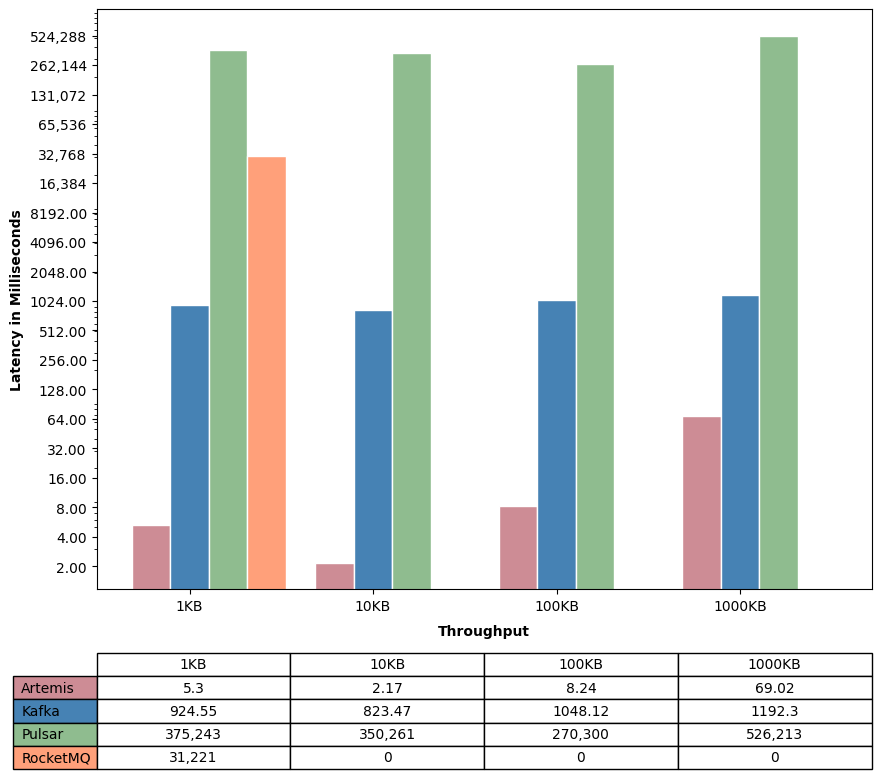

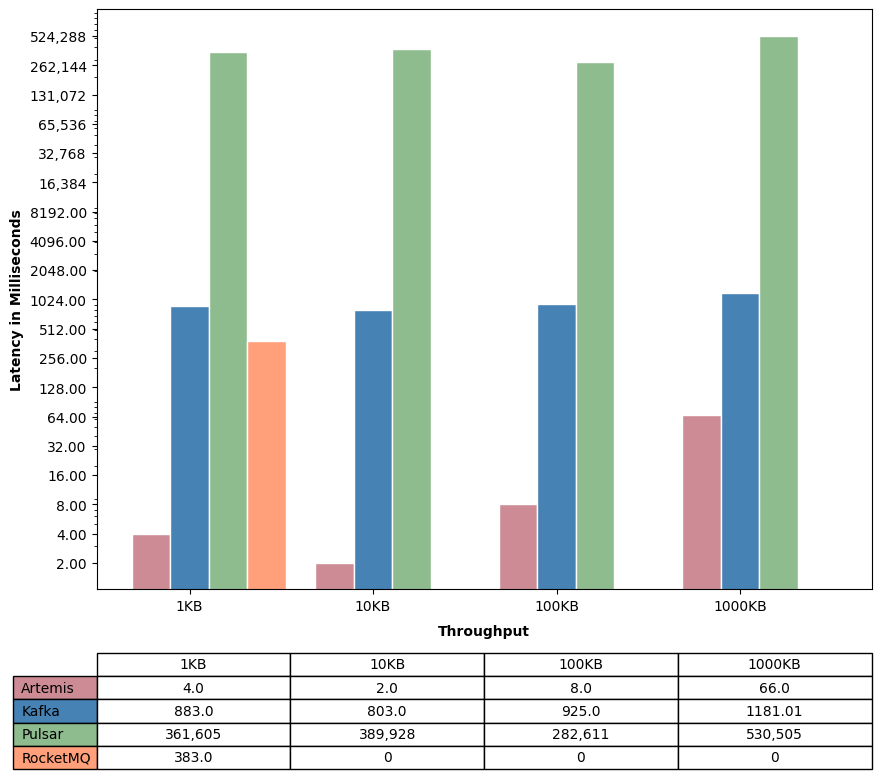

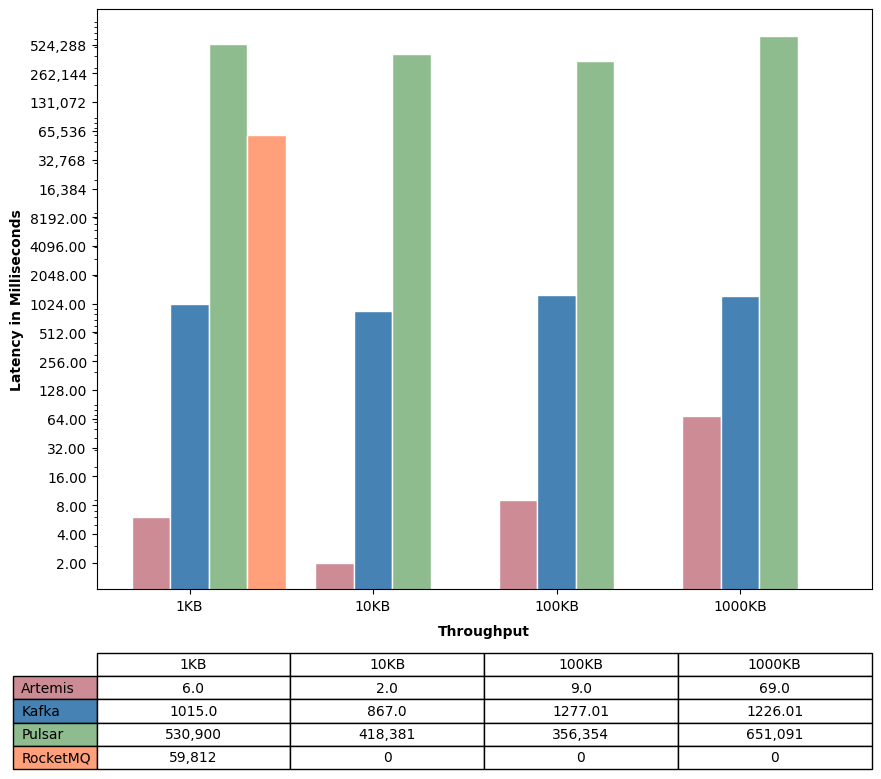

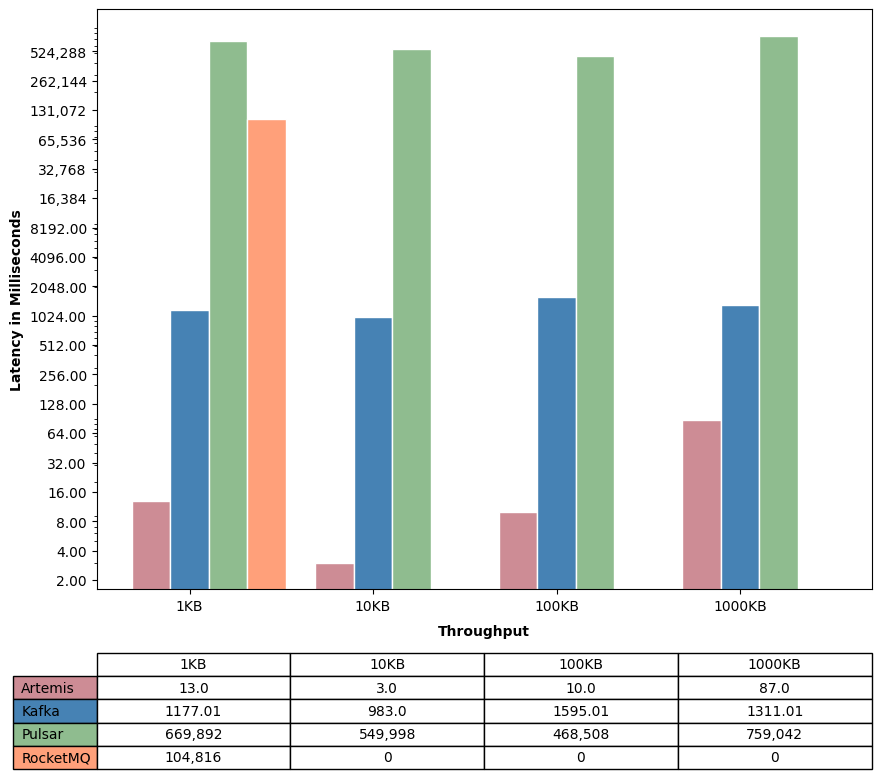

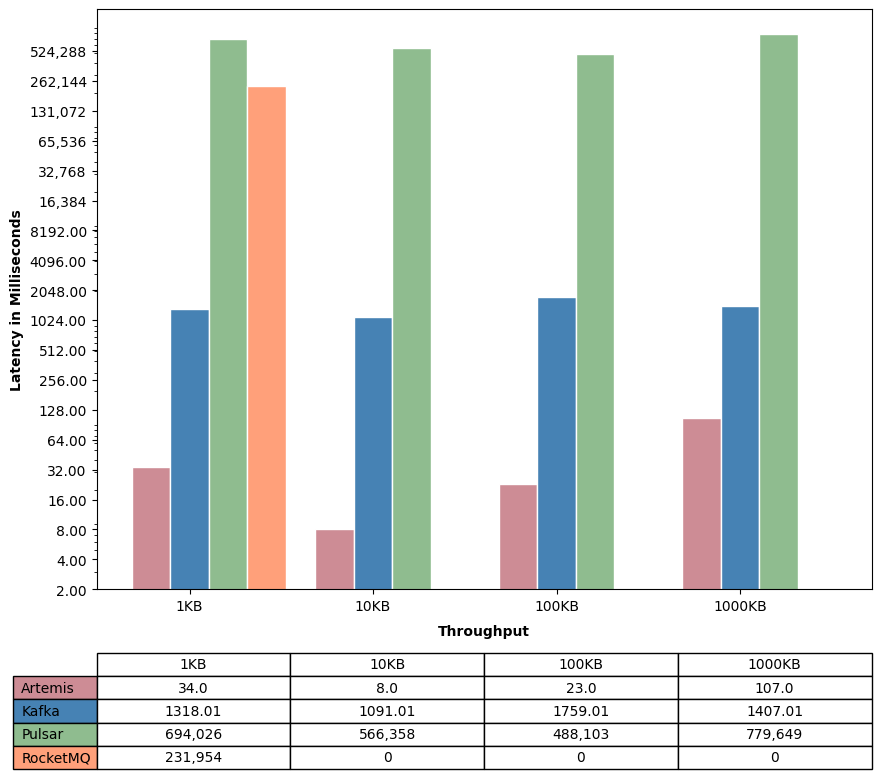

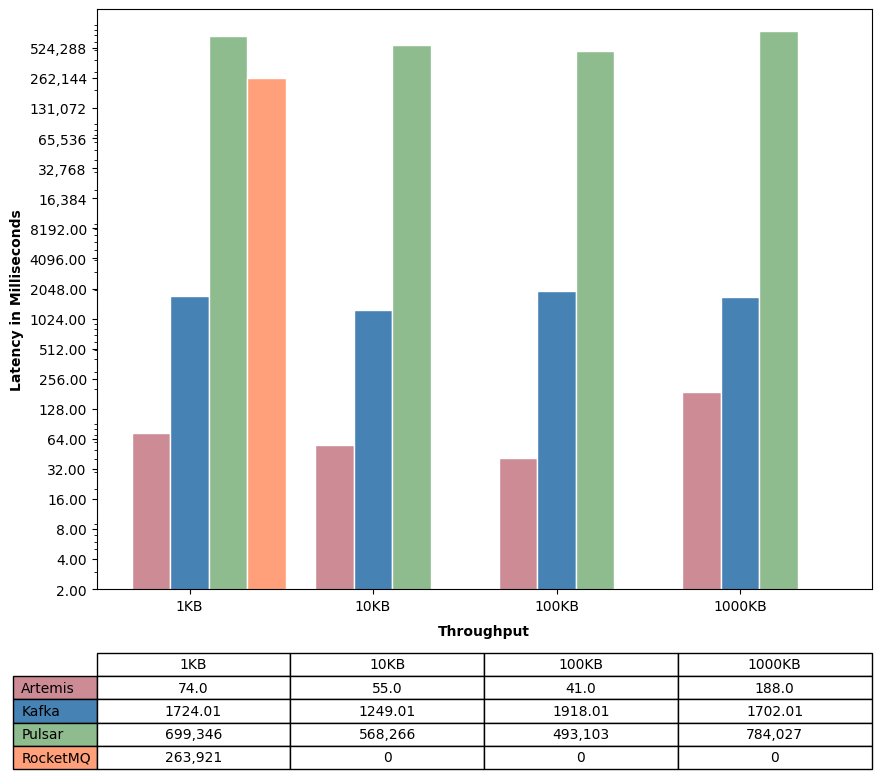

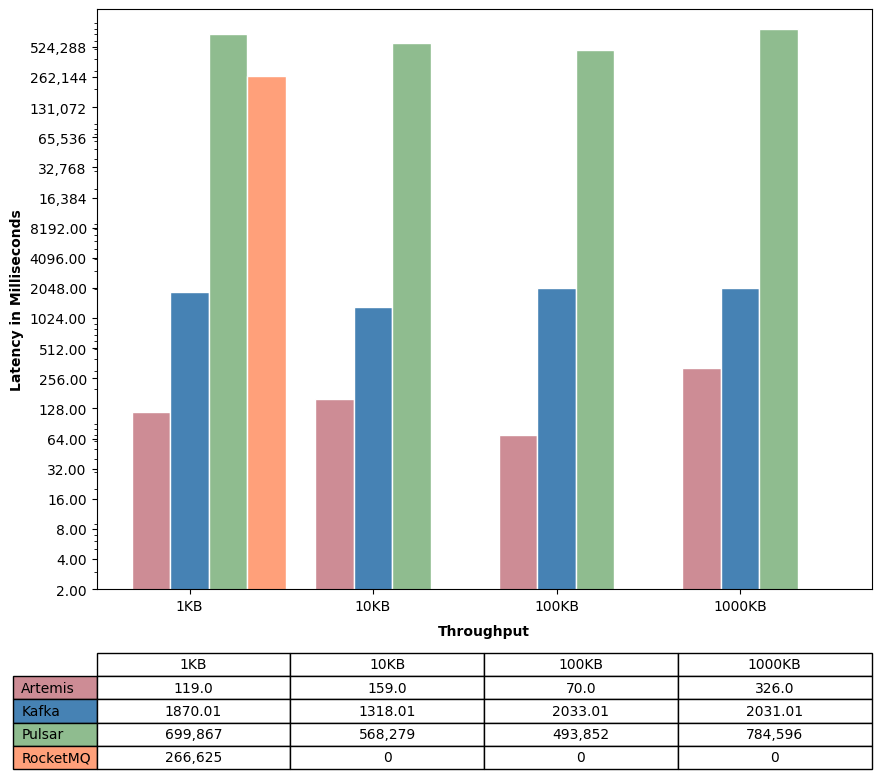

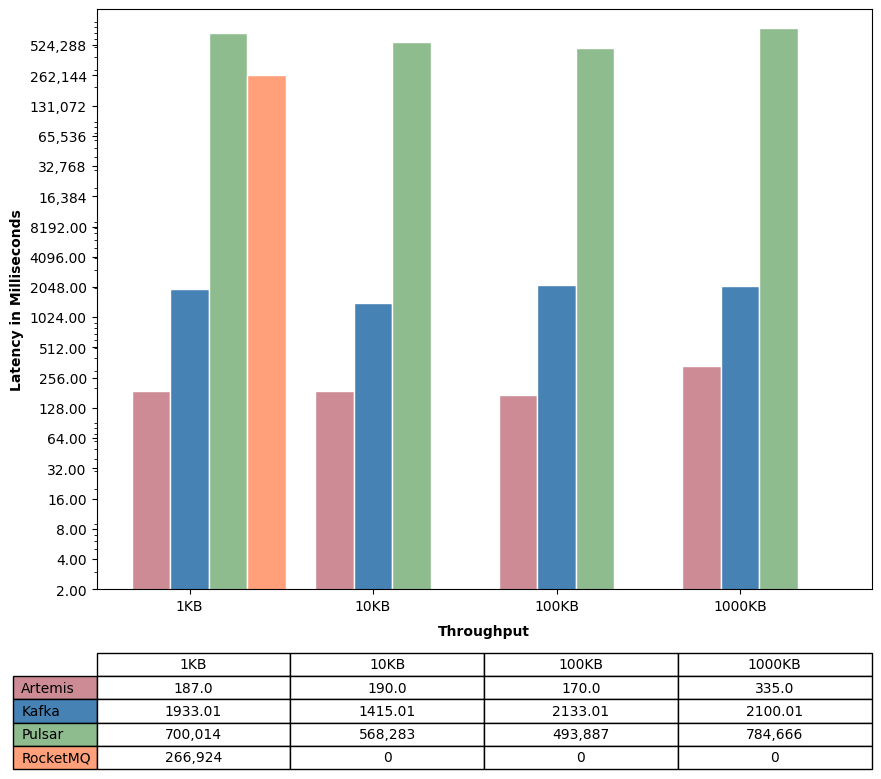

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize(artemis, kafka, pulsar, rocket_mq, cur_label):
  file_sizes = list(sorted_dict.keys())

  bar_width = 0.21
  r1 = np.arange(len(file_sizes))
  r2 = [x + bar_width for x in r1]
  r3 = [x + bar_width for x in r2]
  r4 = [x + bar_width for x in r3]

  #EEE8AA darkseagreen lightslategray darkkhaki
  fig, ax = plt.subplots(figsize=(10, 10))
  # Make the plot
  artemis_bars = ax.bar(r1, artemis, color='#CD8C95', width=bar_width, edgecolor='white', label='Artemis')
  kafka_bars = ax.bar(r2, kafka, color='#4682B4', width=bar_width, edgecolor='white', label='Kafka')
  pulsar_bars = ax.bar(r3, pulsar, color='darkseagreen', width=bar_width, edgecolor='white', label='Pulsar')
  rocket_mq_bars = ax.bar(r4, rocket_mq, color='#FFA07A', width=bar_width, edgecolor='white', label='RocketMQ')

  ax.set_xlabel("Throughput", fontweight='bold')
  ax.set_ylabel('Latency in Milliseconds', fontweight='bold')
  ax.set_xticks([r + bar_width for r in range(len(file_sizes))])
  ax.set_xticklabels(file_sizes)
  ax.xaxis.labelpad = 8
  import locale
  locale.setlocale(locale.LC_ALL, '')  # Set the locale to use comma as the thousands separator

  y_values = [
      [locale.format_string("%d", val, grouping=True) if val >= 10000 else str(val) for val in artemis],
      [locale.format_string("%d", val, grouping=True) if val >= 10000 else str(val) for val in kafka],
      [locale.format_string("%d", val, grouping=True) if val >= 10000 else str(val) for val in pulsar],
      [locale.format_string("%d", val, grouping=True) if val >= 10000 else str(val) for val in rocket_mq]

  ]

# colors = {
#     'artemis': '#CD8C95',  # Gold
#     'kafka': '#4682B4',    # Lime Green
#     'pulsar': 'darkseagreen',   # Royal Blue
#     'rocketmq': '#FFA07A'  # Light Salmon
# }

  legend_colors = ['#CD8C95', '#4682B4', 'darkseagreen', '#FFA07A']
  legend_rows = [Line2D([0], [0], color=color, linewidth=4, linestyle='-') for color in legend_colors]

  y_min = 0.07
  y_max = 260

  y_min = min([min(lst) for lst in [artemis, kafka, pulsar, rocket_mq]])
  y_max = max([max(lst) for lst in [artemis, kafka, pulsar, rocket_mq]])

  ax.set_yscale('log')
  if y_min == 0:
    y_min = 2

  y_ticks = [2**i for i in range(int(np.floor(np.log2(y_min))), int(np.ceil(np.log2(y_max))))]
  if y_max <= 4000:
    y_ticks += [int(y_max) + 150]

  y_tick_labels = [locale.format_string("%d", tick, grouping=True) if tick >= 10000 else '{:.2f}'.format(tick) for tick in y_ticks]
  ax.set_yticks(y_ticks)
  ax.set_yticklabels(y_tick_labels)

  # print(artemis)
  # print(kafka)
  # print(pulsar)
  # print(rocket_mq)
  # print(cur_label)

  ax.table(cellText=y_values,
          rowLabels=['Artemis', 'Kafka', 'Pulsar', 'RocketMQ'],
          rowColours=legend_colors,
          cellLoc='center',
          rowLoc='left',
          loc='bottom',
          bbox=[0, -0.31, 1, 0.2],
          colWidths=[0.1] * len(file_sizes),
          colLabels=file_sizes)

  plt.subplots_adjust(bottom=0.3)

  if cur_label[-1] == '%':
    cur_label = cur_label.rstrip('%')
  plt.savefig(cur_label + '.pdf', dpi=300, bbox_inches='tight', facecolor='white')

def pad_list(lst, desired_length):
    return lst + [0] * (desired_length - len(lst))

def separate_data():
  for i in range(8):
    considering = graph_req[i]
    cur_label = x_axis_label[i]
    # print(considering)
    file_sizes = list(sorted_dict.keys())

    artemis = []
    kafka = []
    pulsar = []
    rocket_mq = []
    new_dict = {'Artemis': 0, 'Kafka': 1, 'Pulsar': 2, "RocketMQ": 3}

    for size in file_sizes:
        key = size
        values = sorted_dict[key]
        for mitem, mvals in values.items():
          if mitem == considering:
            # print(mitem, mvals)
            for litem in mvals:
              for nkey, val in litem.items():
                idx = new_dict[nkey]
                if idx == 0:
                  artemis.append(round(val, 2))
                elif idx == 1:
                  kafka.append(round(val, 2))
                elif idx == 2:
                  pulsar.append(round(val, 2))
                elif idx == 3:
                  rocket_mq.append(round(val, 2))

    rocket_mq = pad_list(rocket_mq, len(pulsar))
    visualize(artemis, kafka, pulsar, rocket_mq, cur_label)
    # break
  return

separate_data()